In [ ]:
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import necessary building blocks
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, ZeroPadding2D, Add
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.engine.input_layer import Input
from keras.initializers import glorot_uniform

import torchvision.transforms as transforms
from tensorflow import keras
from keras import layers

# initialize data

In [ ]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


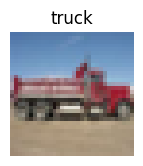

In [ ]:


n_classes = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",  "dog", "frog", "horse", "ship", "truck"]

# show random images from training data
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
        plt.show()

In [ ]:
def prep_imgs(x_train, x_test, y_train, y_test):
  X_train = x_train.astype('float32')
  X_test = x_test.astype('float32')

  X_train/=255
  X_test/=255

  Y_train = np_utils.to_categorical(y_train, len(cifar10_classes))
  Y_test = np_utils.to_categorical(y_test, len(cifar10_classes))

  x_val = X_train[:10000]
  partial_x_train = X_train[10000:]
  y_val = Y_train[:10000]
  partial_y_train = Y_train[10000:]


  gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                          height_shift_range=0.08, zoom_range=0.08)
  val_gen = ImageDataGenerator()
  train_generator = gen.flow(partial_x_train, partial_y_train, batch_size=64)
  val_generator = val_gen.flow(x_val, y_val, batch_size=64)
  return train_generator, val_generator, X_test, Y_test, X_train, Y_train

train_generator, val_generator, X_test, Y_test, X_train, Y_train = prep_imgs(x_train, x_test, y_train, y_test)

# regular

In [ ]:
def make_model(input_shape,n_classes):

  X_input = Input(input_shape)

  # Stage 1
  X = ZeroPadding2D(padding=(3, 3), data_format=None)(X_input)
  X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # Stage 2 for ResNet
  # Save the input value. You'll need this later to add back to the main path.
  X_shortcut = X

  X = ZeroPadding2D(padding=(1, 1), data_format=None)(X)
  X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
  X = Activation('relu')(X)

  X = ZeroPadding2D(padding=(1, 1), data_format=None)(X)
  X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)

  #Add X_shortcut before doing final activation
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  X = Flatten()(X)
  X = Dense(n_classes, activation='softmax', name='fc' + str(n_classes), kernel_initializer = glorot_uniform(seed=0))(X)

  return Model(inputs = X_input, outputs = X, name='ResNet50')


# Create model
input_shape = (32,32,3)
model = make_model(input_shape, n_classes=10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_6[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

# augmented

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
def make_model(input_shape,n_classes):
  # augment images
  X_input = Input(input_shape)

  x = data_augmentation(X_input)

  # Stage 1
  X = ZeroPadding2D(padding=(3, 3), data_format=None)(X_input)
  X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # Stage 2 for ResNet
  # Save the input value. You'll need this later to add back to the main path.
  X_shortcut = X

  X = ZeroPadding2D(padding=(1, 1), data_format=None)(X)
  X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
  X = Activation('relu')(X)

  X = ZeroPadding2D(padding=(1, 1), data_format=None)(X)
  X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)

  #Add X_shortcut before doing final activation
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  X = Flatten()(X)
  X = Dense(n_classes, activation='softmax', name='fc' + str(n_classes), kernel_initializer = glorot_uniform(seed=0))(X)

  return Model(inputs = X_input, outputs = X, name='ResNet50')


# Create model
input_shape = (32,32,3)
model = make_model(input_shape, n_classes=10)
# model.summary()


In [ ]:
model=keras.Sequential()
model.add(Conv2D(filters=32,kernel_size=3,padding="same", 
           activation="relu", input_shape=[32,32,3]))
model.add(Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
model.add(Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
model.add(Flatten())
model.add(Dropout(0.5,noise_shape=None,seed=None))
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=10,activation='softmax'))

model.summary()

In [1]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), 
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_generator, epochs=10,validation_data=val_generator)

score = model.evaluate(X_test, Y_test)
print()
print('Test accuracy: ', score[1])

NameError: ignored

# plot loss

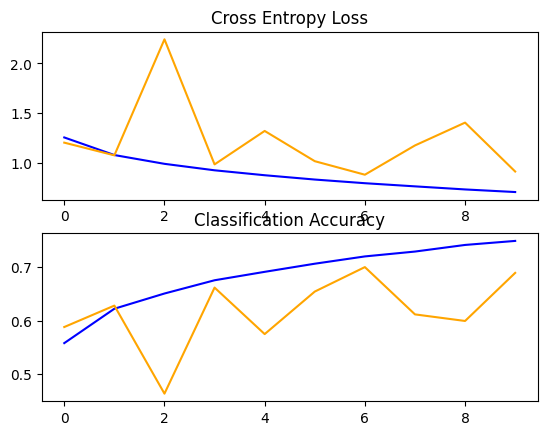

In [ ]:
 # plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')